In [1]:
from google.colab import files
uploaded = files.upload()

Saving ptbdb_normal.csv to ptbdb_normal.csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving ptbdb_abnormal.csv to ptbdb_abnormal.csv


# Введение

Рассмотрим исследование в области обработки и классификации сигналов электрокардиограммы (ЭКГ), используя возможности автокодировщика сверточной нейронной сети (CNN). Выбрана диагностическая база данных ЭКГ PTB. Основная цель — построить надежную модель автоэнкодера, адаптированную для задачи обнаружения аномальных сигналов электрокардиограммы (ЭКГ).

# Обзор набора данных

PTB Diagnostic ECG Database представляет собой набор из 14 552 записей ЭКГ, полученных из диагностической базы данных PTB компании Physionet. Эти сигналы ЭКГ подразделяются на два класса: нормальные сердечные сокращения и нарушения сердечной деятельности. Набор данных отбирается с частотой 125 Гц, что обеспечивает данные высокого разрешения для углубленного анализа.

In [3]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

In [4]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[]

In [5]:
normal_df = pd.read_csv("ptbdb_normal.csv").iloc[:, :-1]
anomaly_df = pd.read_csv("ptbdb_abnormal.csv").iloc[:, :-1]
normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print("Форма нормальных данных", normal_df.shape)
print("Форма аномальных данных", anomaly_df.shape)

Форма нормальных данных (4045, 187)
Форма аномальных данных (10505, 187)


Приведенный ниже код генерирует визуальное сравнение двух случайно выбранных образцов сигнала ЭКГ: одного из набора данных «Нормальный», а другого — из набора данных «Аномалия». Этот параллельный график позволяет провести прямую визуальную оценку структуры сигналов ЭКГ в нормальных и аномальных случаях.

In [7]:
def plot_sample(normal, anomaly):
    index = np.random.randint(0, len(normal_df), 2)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Случай {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Случай {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Нормальный")

    ax[1].plot(anomaly.iloc[index[0], :].values, label=f"Случай {index[0]}")
    ax[1].plot(anomaly.iloc[index[1], :].values, label=f"Случай {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("Аномалия")

    plt.tight_layout()
    plt.show()

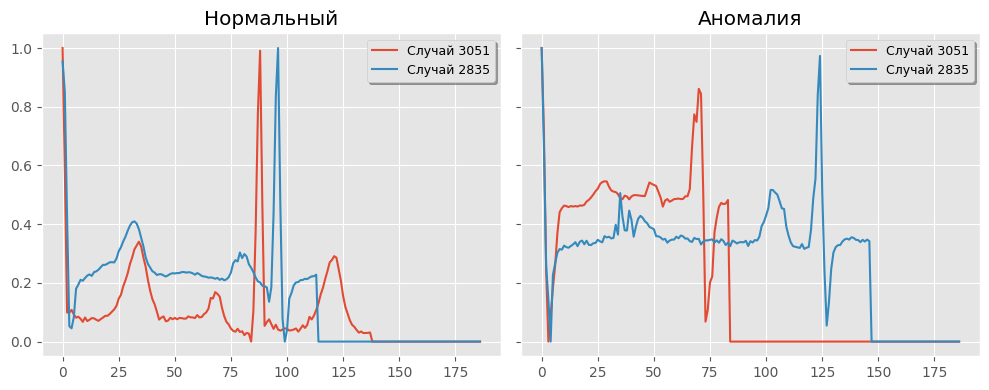

In [8]:
plot_sample(normal_df, anomaly_df)

In [9]:
CLASS_NAMES = ["Нормальный", "Аномалия"]

normal_df_copy = normal_df.copy()
anomaly_df_copy = anomaly_df.copy()
print(anomaly_df_copy.columns.equals(normal_df_copy.columns))

False


In [10]:
normal_df_copy = normal_df_copy.set_axis(range(1, 188), axis=1)
anomaly_df_copy = anomaly_df_copy.set_axis(range(1, 188), axis=1)
normal_df_copy = normal_df_copy.assign(target = CLASS_NAMES[0])
anomaly_df_copy = anomaly_df_copy.assign(target = CLASS_NAMES[1])


df = pd.concat((normal_df_copy, anomaly_df_copy))

# Сглаженный график среднего значения для сравнения классов

В этом коде определена функция под названием plot_smoothed_mean для создания сглаженных средних графиков. В качестве параметров он принимает входные данные, имя класса и размер шага. Функция вычисляет скользящее среднее и стандартное отклонение данных с указанным размером шага, затем отображает сглаженное среднее значение вместе с заштрихованной областью, представляющей границу, в три раза превышающую стандартное отклонение.

Код также демонстрирует использование этой функции для сравнения сглаженных средних значений разных классов. Он создает подсюжет с двумя панелями, каждая из которых представляет отдельный класс. Данные для каждого класса группируются, и среднее значение вычисляется перед передачей его в функцию plot_smoothed_mean. Это позволяет визуализировать сравнение сглаженных средних значений разных классов.

Полученный график дает представление о том, как средние значения разных классов изменяются со временем или по какой-либо другой переменной, представленной данными, при этом заштрихованные области указывают на неопределенность вокруг средних оценок.

In [11]:
def plot_smoothed_mean(data, class_name = "нормальный", step_size=5, ax=None):
    df = pd.DataFrame(data)
    roll_df = df.rolling(step_size)
    smoothed_mean = roll_df.mean().dropna().reset_index(drop=True)
    smoothed_std = roll_df.std().dropna().reset_index(drop=True)
    margin = 3*smoothed_std
    lower_bound = (smoothed_mean - margin).values.flatten()
    upper_bound = (smoothed_mean + margin).values.flatten()

    ax.plot(smoothed_mean.index, smoothed_mean)
    ax.fill_between(smoothed_mean.index, lower_bound, y2=upper_bound, alpha=0.3, color="red")
    ax.set_title(class_name, fontsize=9)

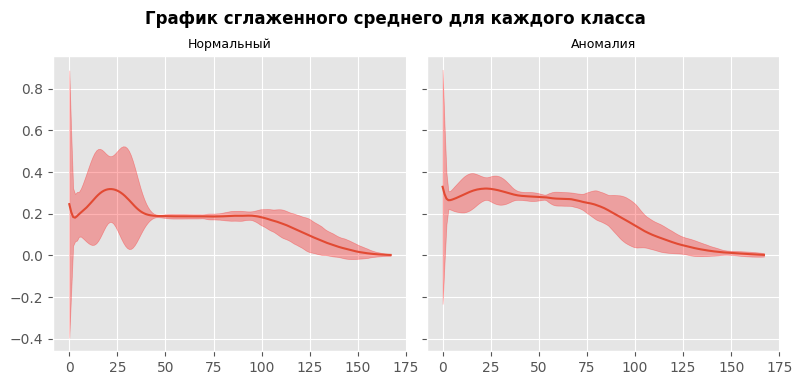

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i, label in enumerate(CLASS_NAMES, start=1):
    data_group = df.groupby("target")
    data = data_group.get_group(label).mean(axis=0, numeric_only=True).to_numpy()
    plot_smoothed_mean(data, class_name=label, step_size=20, ax=axes[i-1])
fig.suptitle("График сглаженного среднего для каждого класса", y=0.95, weight="bold")
plt.tight_layout()

# Разделение данных на обучающий и тестовый наборы

In [13]:
normal_df.drop("target", axis=1, errors="ignore", inplace=True)
normal = normal_df.to_numpy()
anomaly_df.drop("target", axis=1, errors="ignore", inplace=True)
anomaly = anomaly_df.to_numpy()

X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)
print(f"Обучающий пример: {X_train.shape}, Тестовый пример: {X_test.shape}, Аномальный пример: {anomaly.shape}")

Обучающий пример: (3438, 187), Тестовый пример: (607, 187), Аномальный пример: (10505, 187)


# Построение модели автоэнкодера CNN

Об автоэнкодерах: изучение эффективных представлений данных
Автоэнкодеры — это класс архитектур нейронных сетей, обычно используемых в задачах машинного обучения без учителя и глубокого обучения. Их основная цель — обнаружить и изучить эффективные представления данных путем их кодирования в скрытое пространство меньшей размерности и последующего декодирования обратно в исходную форму. Автоэнкодеры играют решающую роль в различных приложениях, таких как уменьшение размерности, шумоподавление данных, обнаружение аномалий и генеративное моделирование.

Основные компоненты автокодировщика состоят из кодера и декодера. Кодер отображает входные данные в скрытое пространство, а декодер восстанавливает данные из их закодированного представления. Во время обучения автоэнкодеры стремятся минимизировать ошибку восстановления между входными и декодированными выходными данными, что приводит к обучению значимых представлений данных.

Автоэнкодеры предлагают универсальный инструмент для извлечения признаков, сжатия данных и многого другого, что делает их ценным дополнением к набору инструментов специалистов по обработке данных и практиков машинного обучения.

In [14]:
tf.keras.utils.set_random_seed(1024)

In [15]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])
        # использование Transposed Convolution .
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


input_dim = X_train.shape[-1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 24, 32)         │        63,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,264 (247.12 KB)

 Trainable params: 62,688 (244.88 KB)

 Non-trainable params: 576 (2.25 KB)

In [16]:
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - loss: 0.1777 - val_loss: 0.1040
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - loss: 0.0941 - val_loss: 0.0860
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - loss: 0.0855 - val_loss: 0.0850
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.0851 - val_loss: 0.0849
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 0.0846 - val_loss: 0.0858
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - loss: 0.0853 - val_loss: 0.0865
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - loss: 0.0856 - val_loss: 0.0852
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - loss: 0.0842 - val_loss: 0.0844
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - loss: 0.0846 - val_loss: 0.0845
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step - loss: 0.0838 - val_loss: 0.0843
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - loss: 0.0836 - val_loss: 0.0841
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━

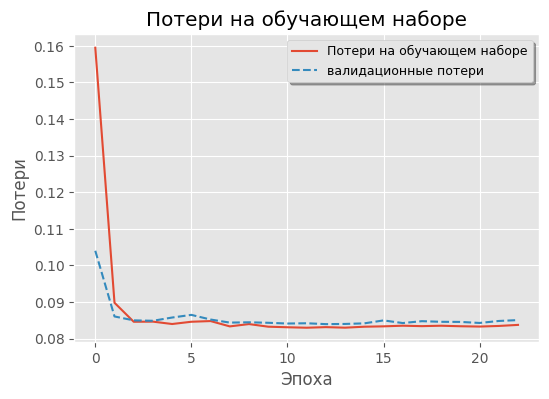

In [17]:
plt.plot(history.history['loss'], label="Потери на обучающем наборе")
plt.plot(history.history['val_loss'], label="валидационные потери", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Потери на обучающем наборе")
plt.ylabel("Потери")
plt.xlabel("Эпоха")
plt.show()

In [18]:
train_mae = model.evaluate(X_train, X_train, verbose=0)
test_mae = model.evaluate(X_test, X_test, verbose=0)
anomaly_mae = model.evaluate(anomaly_df, anomaly_df, verbose=0)

print("Ошибки на обучающем наборе данных: ", train_mae)
print("Ошибка на тестовом наборе данных: ", test_mae)
print("Ошибка на аномальном наборе данных:  ", anomaly_mae)

Ошибки на обучающем наборе данных:  0.08286198228597641
Ошибка на тестовом наборе данных:  0.08428030461072922
Ошибка на аномальном наборе данных:   0.11922167241573334


In [19]:
def predict(model, X):
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss

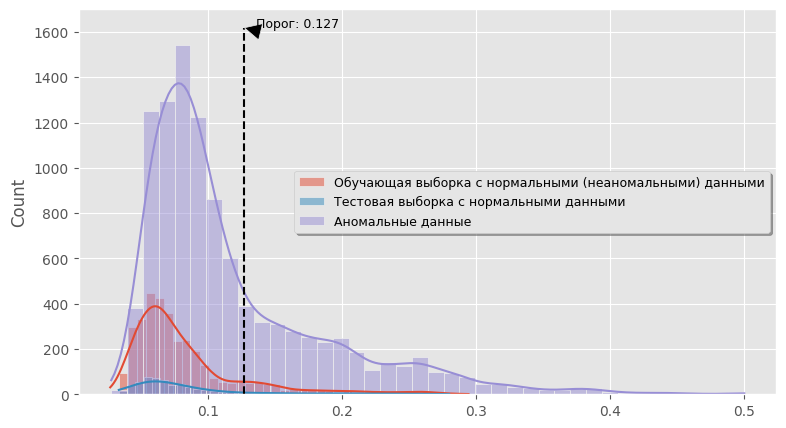

In [20]:
_, train_loss = predict(model, X_train)
_, test_loss = predict(model, X_test)
_, anomaly_loss = predict(model, anomaly)
threshold = np.mean(train_loss) + np.std(train_loss) # Установка порога для различения нормальных данных от аномальных

bins = 40
plt.figure(figsize=(9, 5), dpi=100)
sns.histplot(np.clip(train_loss, 0, 0.5), bins=bins, kde=True, label="Обучающая выборка с нормальными (неаномальными) данными")
sns.histplot(np.clip(test_loss, 0, 0.5), bins=bins, kde=True, label="Тестовая выборка с нормальными данными")
sns.histplot(np.clip(anomaly_loss, 0, 0.5), bins=bins, kde=True, label="Аномальные данные")

ax = plt.gca()  # Get the current Axes
ylim = ax.get_ylim()
plt.vlines(threshold, 0, ylim[-1], color="k", ls="--")
plt.annotate(f"Порог: {threshold:.3f}", xy=(threshold, ylim[-1]), xytext=(threshold+0.009, ylim[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9)
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.show()

In [21]:
def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Актуальные")
    ax.plot(pred[0], label = "Предсказанные")
    ax.fill_between(range(1, 188), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True,
              facecolor="inherit", loc=1, fontsize=7)
#                bbox_to_anchor = (0, 0, 0.8, 0.25))

    ax.set_title(f"{title} (потери: {loss[0]:.3f})", fontsize=9.5)

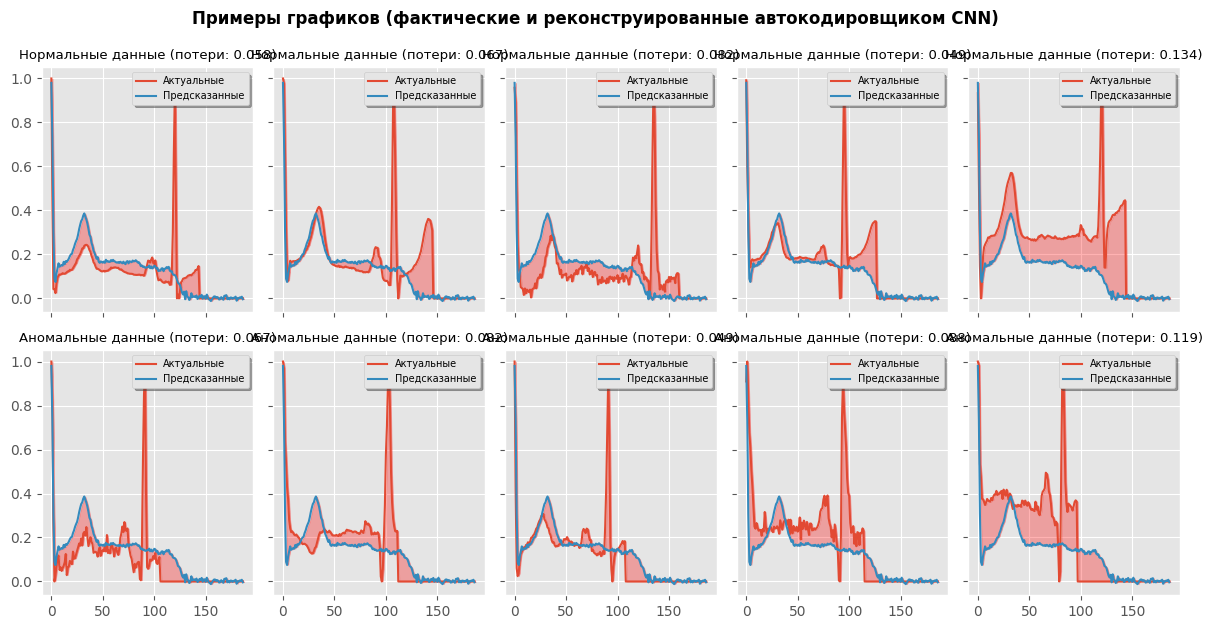

In [22]:
fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6))
random_indexes = np.random.randint(0, len(X_train), size=5)

for i, idx in enumerate(random_indexes):
    data = X_train[[idx]]
    plot_examples(model, data, ax=axes[0, i], title="Нормальные данные")

for i, idx in enumerate(random_indexes):
    data = anomaly[[idx]]
    plot_examples(model, data, ax=axes[1, i], title="Аномальные данные")

plt.tight_layout()
fig.suptitle("Примеры графиков (фактические и реконструированные автокодировщиком CNN)", y=1.04, weight="bold")
fig.savefig("autoencoder.png")
plt.show()

# Оценка модели

In [25]:
def evaluate_model(model, data):
    pred, loss = predict(model, data)
    if id(data) == id(anomaly):
        accuracy = np.sum(loss > threshold)/len(data)
    else:
        accuracy = np.sum(loss <= threshold)/len(data)
    return f"точность: {accuracy:.2%}"


In [26]:
print("На обучающем наборе данных", evaluate_model(model, X_train))
print("На тестовом наборе данных", evaluate_model(model, X_test))
print("На аномальных данных", evaluate_model(model, anomaly))

На обучающем наборе данных точность: 87.00%
На тестовом наборе данных точность: 86.66%
На аномальных данных точность: 30.16%


In [27]:
def prepare_labels(model, train, test, anomaly, threshold=threshold):
    ytrue = np.concatenate((np.ones(len(X_train)+len(X_test), dtype=int), np.zeros(len(anomaly), dtype=int)))
    _, train_loss = predict(model, train)
    _, test_loss = predict(model, test)
    _, anomaly_loss = predict(model, anomaly)
    train_pred = (train_loss <= threshold).numpy().astype(int)
    test_pred = (test_loss <= threshold).numpy().astype(int)
    anomaly_pred = (anomaly_loss < threshold).numpy().astype(int)
    ypred = np.concatenate((train_pred, test_pred, anomaly_pred))

    return ytrue, ypred

In [29]:
def plot_confusion_matrix(model, train, test, anomaly, threshold=threshold):
    ytrue, ypred = prepare_labels(model, train, test, anomaly, threshold=threshold)
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)
    print(f"""\
        Accuracy: {accuracy:.2%}
        Precision: {precision:.2%}
        Recall: {recall:.2%}
        f1: {f1:.2%}\n
        """)

    cm = confusion_matrix(ytrue, ypred)
    cm_norm = confusion_matrix(ytrue, ypred, normalize="true")
    data = np.array([f"{count}\n({pct:.2%})" for count, pct in zip(cm.ravel(), cm_norm.ravel())]).reshape(cm.shape)
    labels = ["Аномальные", "Нормальные"]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=data, fmt="", xticklabels=labels, yticklabels=labels)
    plt.ylabel("Фактические значения")
    plt.xlabel("Предсказанные значения")
    plt.title("Матрица ошибок", weight="bold")
    plt.tight_layout()

        Accuracy: 45.95%
        Precision: 32.40%
        Recall: 86.95%
        f1: 47.21%

        


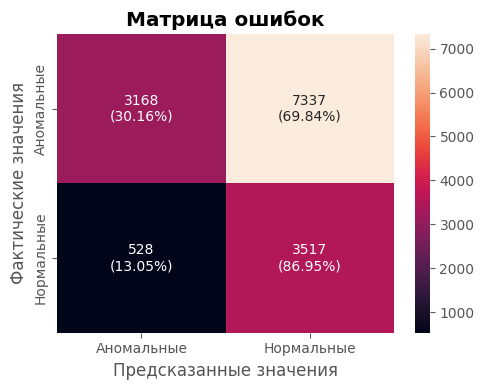

In [30]:
plot_confusion_matrix(model, X_train, X_test, anomaly, threshold=threshold)

# Метрики оценки модели

### Следующие метрики оценки дают комплексную оценку эффективности модели:

Accuracy (76.93%): Accuracy измеряет долю правильных прогнозов среди всех прогнозов, сделанных моделью, что указывает на исключительно высокую общую правильность классификации.

Precision (55.23%): Precision — это процент истинно положительных прогнозов по отношению ко всем положительным прогнозам, сделанным моделью, что означает точность модели в правильном выявлении положительных случаев.

Recall (89.81%): Recall представляет собой способность модели точно идентифицировать положительные случаи среди всех фактических положительных случаев, демонстрируя сильную способность улавливать истинные положительные случаи..

F1 Score (65.40%): Оценка F1 — это составной показатель, который уравновешивает точность и полноту, обеспечивая общую оценку производительности модели.

In [31]:
ytrue, ypred = prepare_labels(model, X_train, X_test, anomaly, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

  Нормальный       0.86      0.30      0.45     10505
    Аномалия       0.32      0.87      0.47      4045

    accuracy                           0.46     14550
   macro avg       0.59      0.59      0.46     14550
weighted avg       0.71      0.46      0.45     14550

